In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
from sklearn import linear_model, model_selection, preprocessing
from yellowbrick.regressor import ResidualsPlot


In [3]:
training_data=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')

In [4]:
test_data=pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# EDA 

## numeric fields

In [5]:
training_data.id.isna().sum()

0

/opt/conda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='model_year', ylabel='price'>

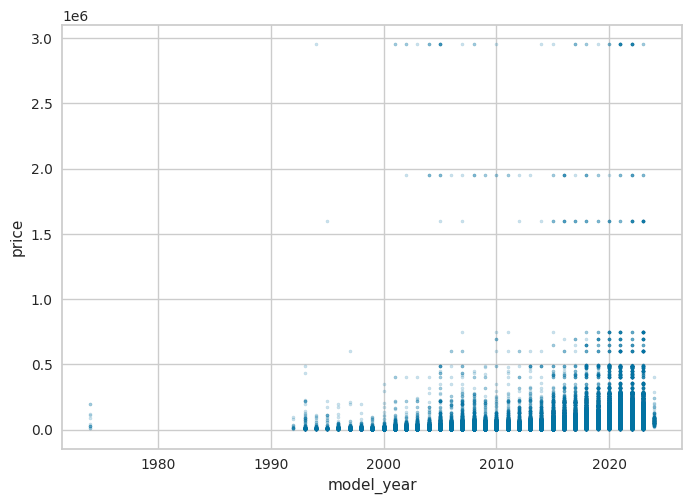

In [6]:
training_data.plot(kind='scatter',y='price',x='model_year',marker='.',alpha=0.2)

Note that this is not timeseries data, it's cross sectional data. Current prices of different cars made in different years, not the prices at the time of the same group of cars year after year.

<Axes: xlabel='model_year', ylabel='price'>

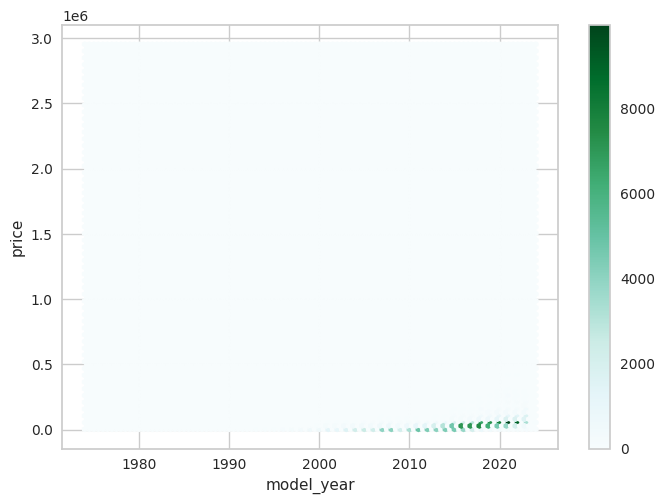

In [7]:
training_data.plot(kind='hexbin',y='price',x='model_year')

In [8]:
print(str(training_data.model_year.min())+'-'+str(training_data.model_year.max()))

1974-2024


In [9]:
training_data.model_year.isna().sum()

0

In [10]:
training_data.groupby('model_year').count()['id'].sort_index().iloc[0:15]

model_year
1974      12
1992      14
1993     140
1994      92
1995     102
1996     189
1997     312
1998     343
1999     554
2000     558
2001    1534
2002    1282
2003    1906
2004    2570
2005    3129
Name: id, dtype: int64

1974 an outlier

In [11]:
training_data.price.isna().sum()

0

/opt/conda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='milage', ylabel='price'>

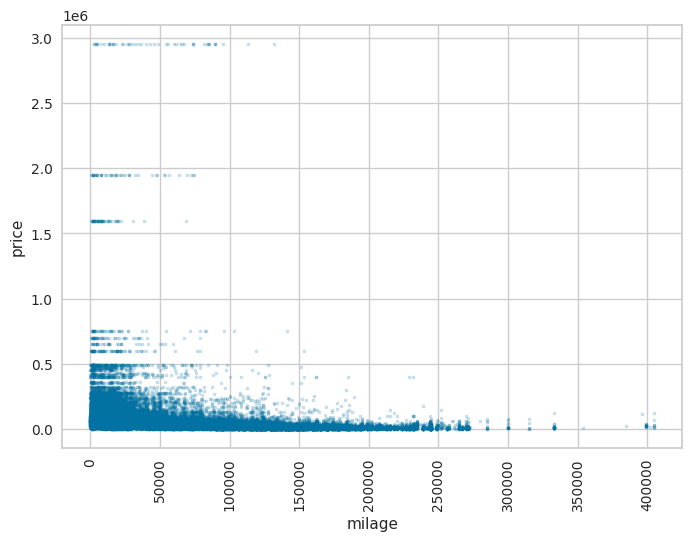

In [12]:
training_data.plot(kind='scatter',y='price',x='milage',marker='.',alpha=0.2,rot=90)

<Axes: xlabel='milage', ylabel='price'>

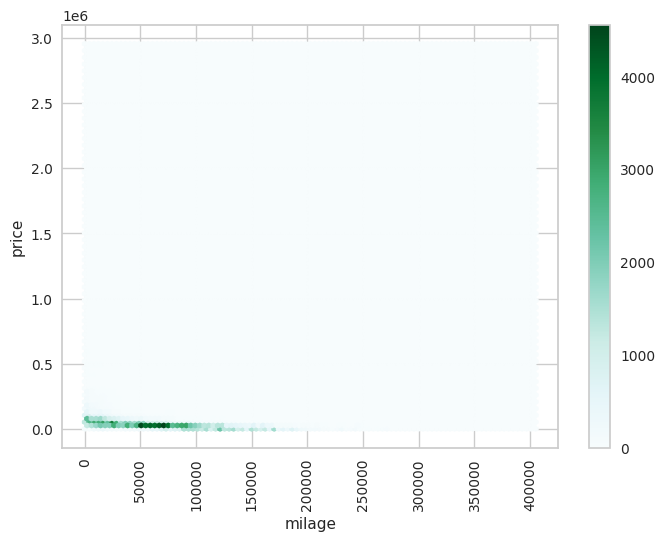

In [13]:
training_data.plot(kind='hexbin',y='price',x='milage',rot=90)

<Axes: xlabel='milage', ylabel='price'>

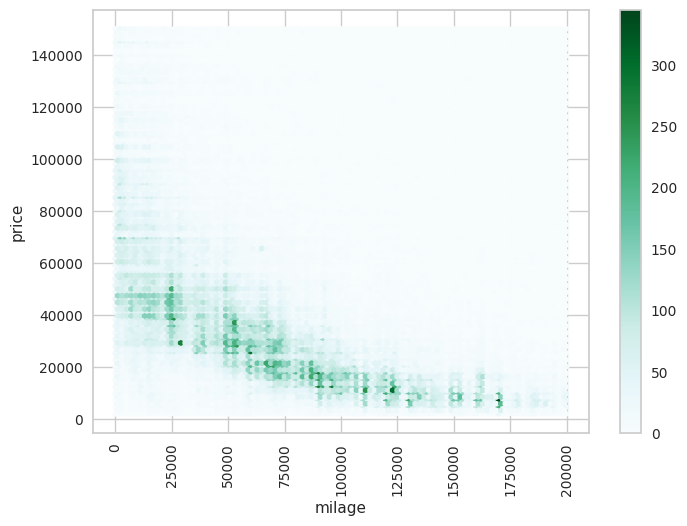

In [14]:
training_data.query('price<150_000 and milage<200_000').plot(kind='hexbin',y='price',x='milage',rot=90)

In [15]:
print(str(training_data.milage.min())+'-'+str(training_data.milage.max()))

100-405000


In [16]:
training_data.groupby('milage').count()['id'].sort_index(ascending=False).iloc[0:15]

milage
405000     8
402000     1
399000    14
395963     1
385000     1
354000     1
333361    26
315000     6
300183     5
300000    10
285000    11
279700     1
272400     1
272000     2
271000    46
Name: id, dtype: int64

outliers above 280k

array([[<Axes: xlabel='model_year', ylabel='model_year'>,
        <Axes: xlabel='milage', ylabel='model_year'>,
        <Axes: xlabel='price', ylabel='model_year'>],
       [<Axes: xlabel='model_year', ylabel='milage'>,
        <Axes: xlabel='milage', ylabel='milage'>,
        <Axes: xlabel='price', ylabel='milage'>],
       [<Axes: xlabel='model_year', ylabel='price'>,
        <Axes: xlabel='milage', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>]], dtype=object)

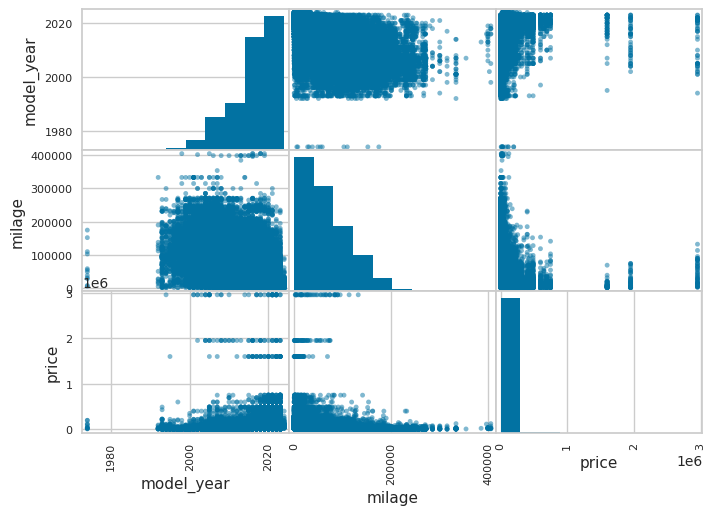

In [17]:
pd.plotting.scatter_matrix(training_data[['model_year','milage','price']])

In [18]:
(training_data
 [['model_year','milage','price']]
 .corr()
)

,model_year,milage,price
model_year,1.000000,-0.669936,0.231795
milage,-0.669936,1.000000,-0.283067
price,0.231795,-0.283067,1.000000


Strong relationship between mileage and year makes sense. But very weak relationship of either with price

In [19]:
(training_data
 [['model_year','milage','price']]
 .corr(method='spearman') 
 #.style
 #.background_gradient(cmap='RdBu')
)

,model_year,milage,price
model_year,1.000000,-0.738150,0.727159
milage,-0.738150,1.000000,-0.742709
price,0.727159,-0.742709,1.000000


price monotonic but non linear in relation to milage/year

## Price outliers

<Axes: xlabel='price'>

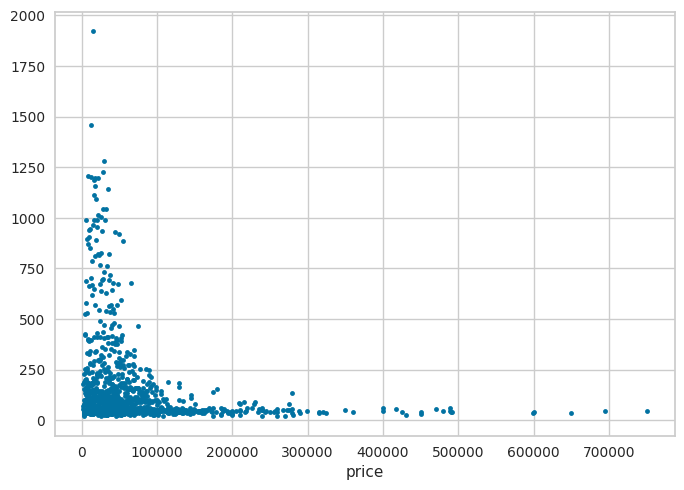

In [20]:
training_data.query('price<1_000_000').groupby('price').count()['id'].plot(marker='.',ls='')

In [21]:
training_data.groupby('price').count()['id'].sort_index(ascending=False).iloc[0:25]

price
2954083    50
1950995    47
1599000    51
749950     48
695000     45
649999     34
599995     41
599000     36
491836     40
489995     40
489000     59
488880     44
479995     46
469900     57
449995     42
449991     30
429998     27
425000     43
417500     58
399950     61
399900     45
359991     41
349950     50
324995     38
319900     43
Name: id, dtype: int64

Definite outliers above 6 digits, and also a gap at 500k

In [22]:
training_data.query('price==2954083')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
220,220,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Agate Black Metallic,Black,None reported,Yes,2954083
1880,1880,Chrysler,300C Base,2003,55900,Gasoline,340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,5-Speed A/T,Beige,Beige,None reported,Yes,2954083
13838,13838,Toyota,Highlander SE,2014,85000,Gasoline,3.5L V6 24V PDI DOHC,8-Speed Automatic,Green,Black,None reported,Yes,2954083
14693,14693,Hyundai,Santa Fe SEL,2022,13865,Gasoline,2.5L I4 16V PDI DOHC,8-Speed Automatic,Black,Black,None reported,Yes,2954083
16034,16034,Mercedes-Benz,SL-Class SL500 Roadster,2005,34068,Gasoline,302.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Beige,None reported,Yes,2954083
18946,18946,Audi,S4 Base,2004,73500,Gasoline,340.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Beige,None reported,Yes,2954083
21814,21814,RAM,1500 Laramie,2022,16156,Gasoline,5.7L V8 16V MPFI OHV,8-Speed Automatic,Diamond Black,Black,None reported,NaN,2954083
36615,36615,Ford,Excursion Limited Ultimate,2002,89900,Diesel,325.0HP 6.0L 8 Cylinder Engine Diesel Fuel,5-Speed A/T,Gold,Gold,None reported,Yes,2954083
42177,42177,Ford,Mustang GT,2005,82000,Gasoline,300.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,5-Speed M/T,Silver,Black,None reported,Yes,2954083
42219,42219,Land,Rover Range Rover 3.0L V6 Supercharged HSE,2021,29850,Gasoline,380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,2954083


What do these have in common?

In [23]:
training_data.query('price==1950995')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
2964,2964,Porsche,911 R,2023,714,Gasoline,4.0L H6 24V GDI DOHC,6-Speed Manual,White,Gray,None reported,Yes,1950995
8789,8789,Lamborghini,Gallardo LP570-4 Superleggera,2011,3254,Gasoline,5.2L V10 40V GDI DOHC,7-Speed Automatic with Auto-Shift,Nero Noctis,Nero Ade,None reported,Yes,1950995
10173,10173,Mercedes-Benz,AMG GLS 63 4MATIC,2019,4102,Gasoline,603.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,9-Speed A/T,Red,Black,None reported,Yes,1950995
21523,21523,BMW,M3 CS,2018,7500,Gasoline,543.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Silver,Black,None reported,Yes,1950995
31429,31429,Chevrolet,Corvette Base,2002,15443,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Beige,None reported,Yes,1950995
32645,32645,Bentley,Continental GT Speed,2016,27981,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic,–,Hotspur,NaN,NaN,1950995
32903,32903,Bentley,Continental GTC Base,2012,18000,E85 Flex Fuel,552.0HP 6.0L 12 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,NaN,NaN,1950995
34801,34801,Mercedes-Benz,SL-Class SL550 Roadster,2004,13250,Gasoline,382.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes,1950995
35218,35218,Chevrolet,Corvette Base,2010,34500,Gasoline,400.0HP 6.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Blue,Blue,At least 1 accident or damage reported,Yes,1950995
36231,36231,Ford,F-250 Lariat,2018,47850,Diesel,475.0HP 6.7L 8 Cylinder Engine Diesel Fuel,A/T,White,–,At least 1 accident or damage reported,Yes,1950995


again, what do they have in common? but by the way, note accident NaN :(

In [24]:
training_data.query('price==1599000')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
4164,4164,Rolls-Royce,Ghost Base,2016,38800,Gasoline,563.0HP 6.7L 12 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,1599000
15101,15101,Porsche,911 Carrera S,2015,7800,Gasoline,400.0HP 3.8L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,White,Black,None reported,Yes,1599000
16417,16417,Bentley,Bentayga Speed,2020,2165,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,Ice,Beluga Hide,None reported,Yes,1599000
17859,17859,Land,Rover Range Rover Sport HSE,2019,5844,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,1599000
18614,18614,Lamborghini,Huracan LP580-2,2017,22000,Gasoline,573.0HP 5.2L 10 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,1599000
19118,19118,BMW,M4 Base,2019,18000,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,7-Speed A/T,Black,Red,None reported,Yes,1599000
19379,19379,Tesla,Model X Performance,2023,159,NaN,778.0HP Electric Motor Electric Fuel System,A/T,Blue,Black,None reported,Yes,1599000
27807,27807,Land,Rover Range Rover P530 SE LWB 7 Seat,2023,1538,Gasoline,523.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Green,Green,None reported,Yes,1599000
32219,32219,Porsche,911 GT3,2018,9712,Gasoline,4.0L H6 24V GDI DOHC,7-Speed Automatic with Auto-Shift,Gray,–,None reported,Yes,1599000
32389,32389,Land,Rover Range Rover Sport SVR Carbon Edition,2022,19250,Gasoline,575.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,9-Speed A/T,Black,Red,None reported,Yes,1599000


Note fuel nan

## Brands and models

<Axes: ylabel='brand'>

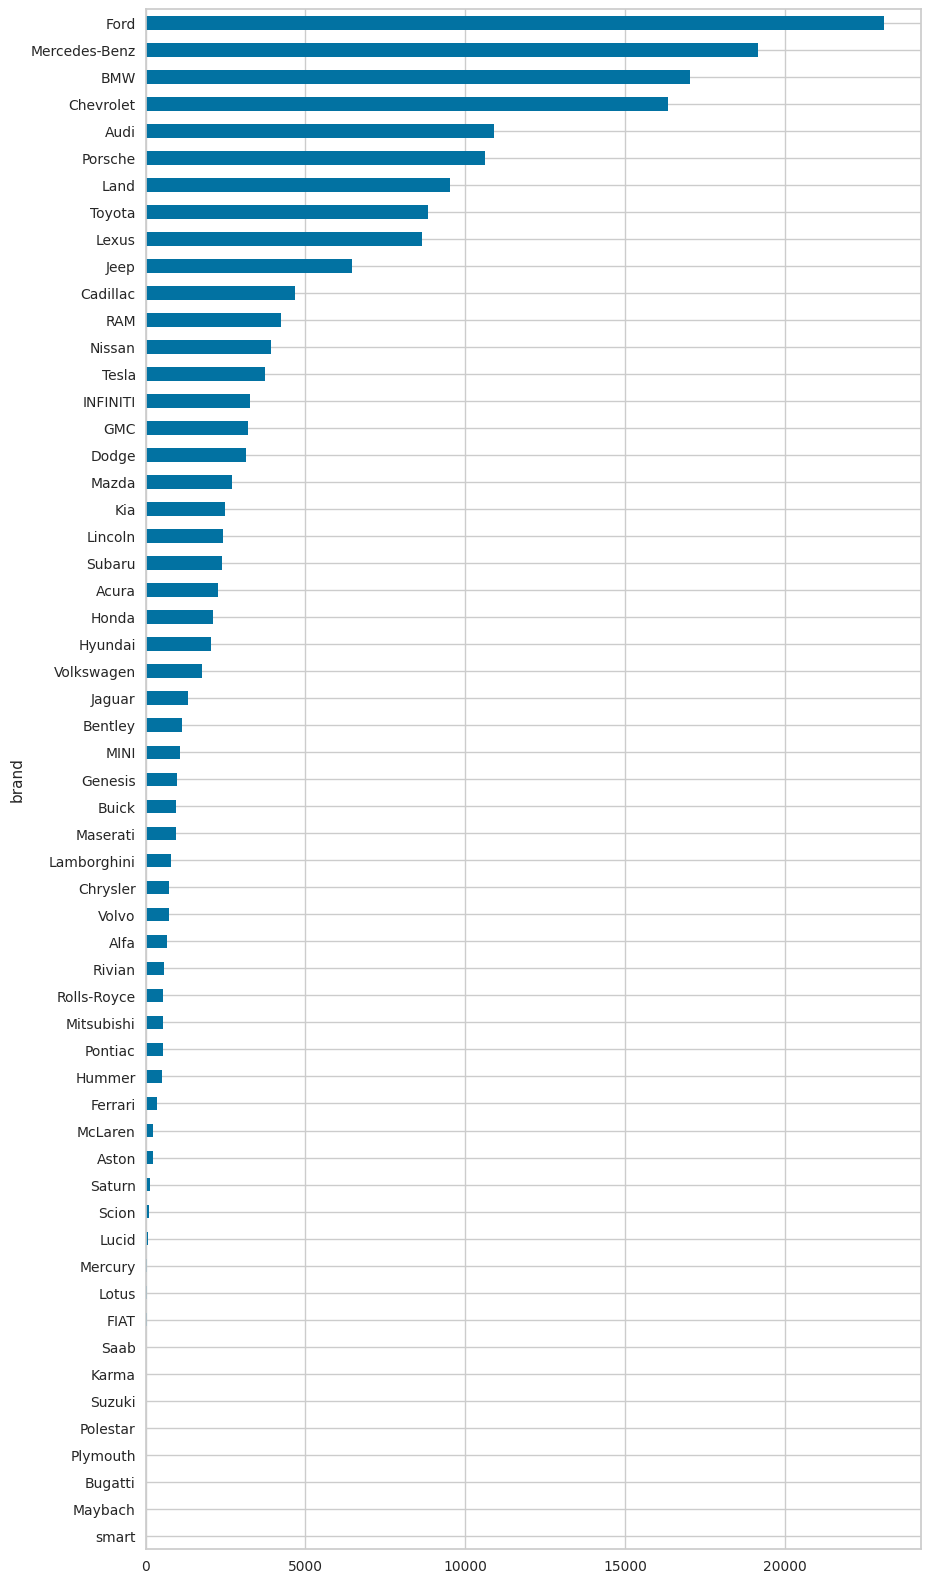

In [25]:
training_data.groupby('brand').count()['id'].sort_values().plot(kind='barh',figsize=[10,20])

In [26]:
training_data.brand.isna().sum()

0

In [27]:
training_data.model.isna().sum()

0

<Axes: ylabel='brand,model'>

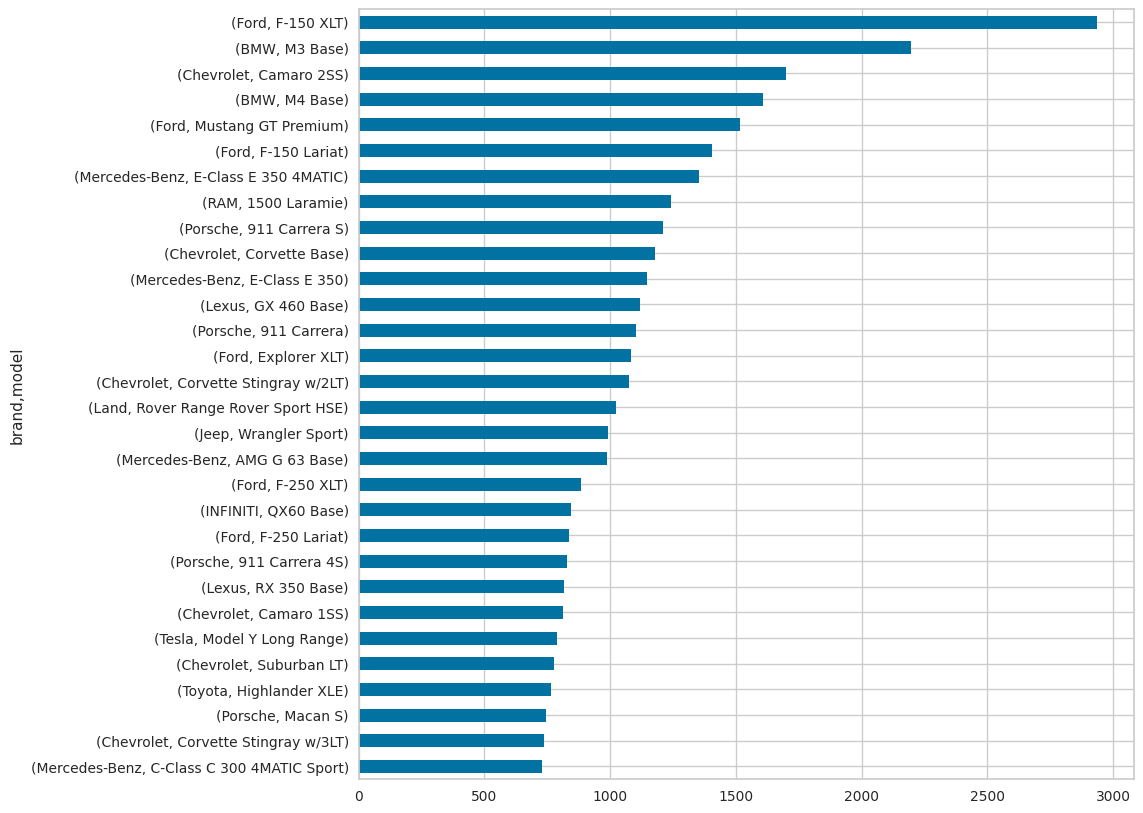

In [28]:
training_data.groupby(['brand','model']).count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

## Engines and Fuel

<Axes: xlabel='fuel_type'>

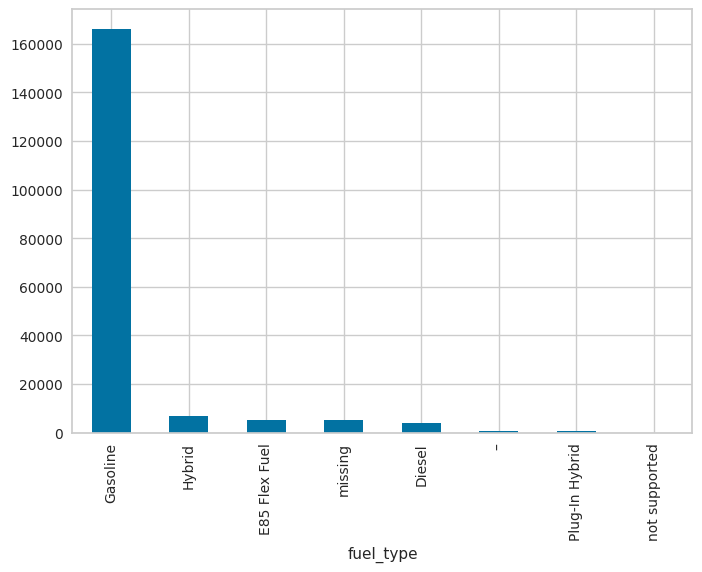

In [29]:
training_data.fillna("missing").groupby('fuel_type').count()['id'].sort_values(ascending=False).plot(kind='bar')

<Axes: >

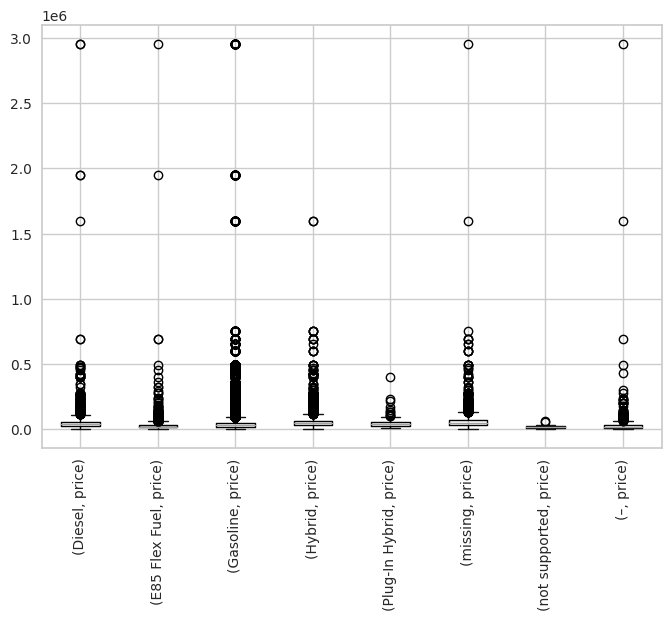

In [30]:
training_data.fillna("missing")[['price','fuel_type']].groupby('fuel_type').boxplot(subplots=False,rot=90)

<Axes: >

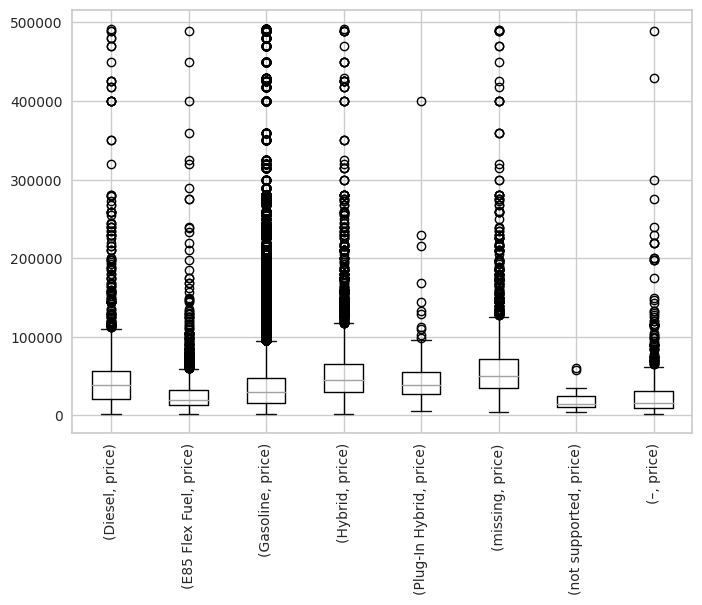

In [31]:
training_data.fillna("missing").query('price<500_000')[['price','fuel_type']].groupby('fuel_type').boxplot(subplots=False,rot=90)

In [32]:
training_data.fillna("missing").groupby('fuel_type').count()['id'].sort_values(ascending=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
missing             5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: id, dtype: int64

Problematic data for some entries here. More missing entries than Diesel! A lot of '-' and a few 'not supported'

In [33]:
test_data.fillna("missing").groupby('fuel_type').count()['id'].sort_values(ascending=False)

fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
missing             3383
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: id, dtype: int64

Test data suffers from same issues

Could possibly derive fuel from engine

<Axes: ylabel='engine'>

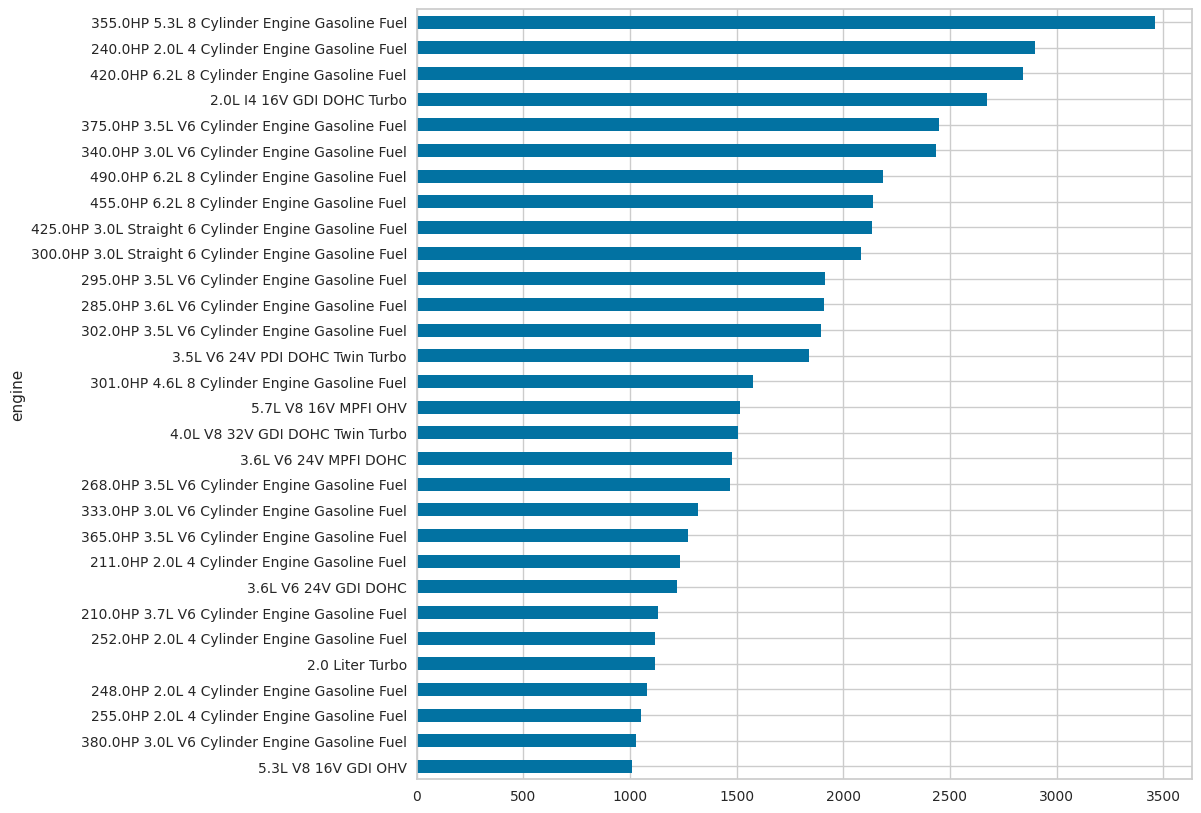

In [34]:
training_data.query('fuel_type=="Gasoline"').groupby('engine').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

extract HP as number, L as number?

In [35]:
training_data.query('fuel_type=="Gasoline"').engine.str.extract(r'(\d+)\sCylinder').fillna('0').astype('int')

,0
0,4
1,8
3,8
4,4
5,4
...,...
188528,8
188529,6
188530,8
188531,0


array([[<Axes: title={'center': '0'}>]], dtype=object)

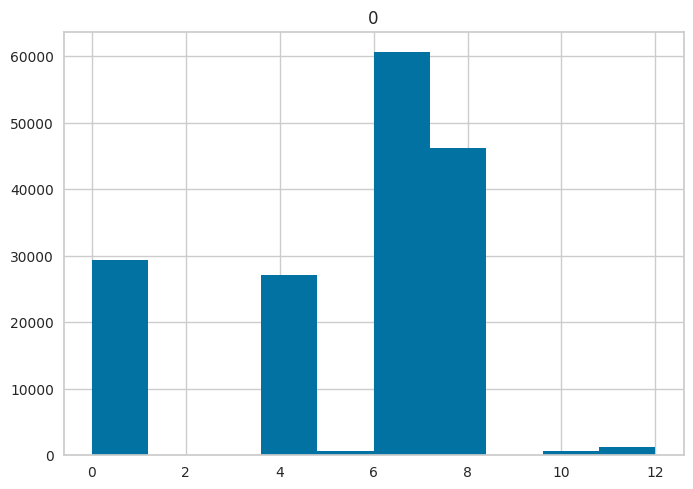

In [36]:
training_data.query('fuel_type=="Gasoline"').engine.str.extract(r'(\d+)\sCylinder').fillna('0').astype('int').hist()


In [37]:
training_data.query('fuel_type=="Gasoline"').engine.str.extract(r'(\d+\.\d)HP').fillna('0.0').astype('float')#.isna().sum()#errors='ignore'


,0
0,172.0
1,252.0
3,420.0
4,208.0
5,252.0
...,...
188528,420.0
188529,385.0
188530,469.0
188531,0.0


Careful as HP not always stated. L is not taken as long number. 

array([[<Axes: title={'center': '0'}>]], dtype=object)

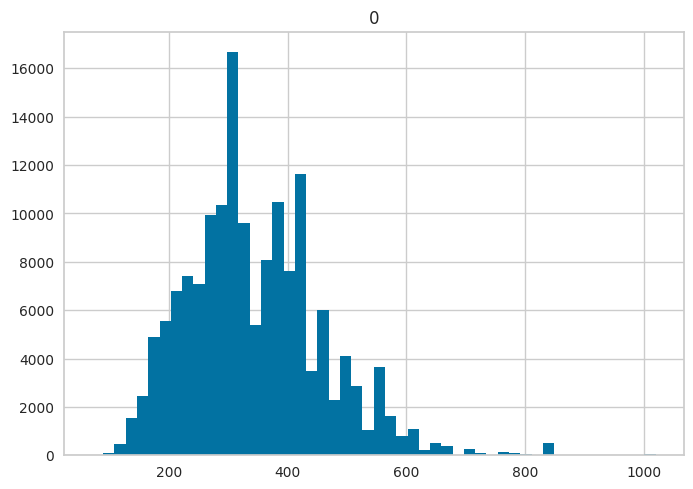

In [38]:
training_data.engine.str.extract(r'(\d+\.\d)HP').astype('float').hist(bins=50)#.isna().sum()#errors='ignore'


In [39]:
training_data.query('fuel_type=="Gasoline"').engine.str.extract(r'(\d+\.\d)L').astype('float')

,0
0,1.6
1,3.9
3,5.0
4,2.0
5,2.0
...,...
188528,6.2
188529,3.0
188530,4.0
188531,3.0


array([[<Axes: title={'center': '0'}>]], dtype=object)

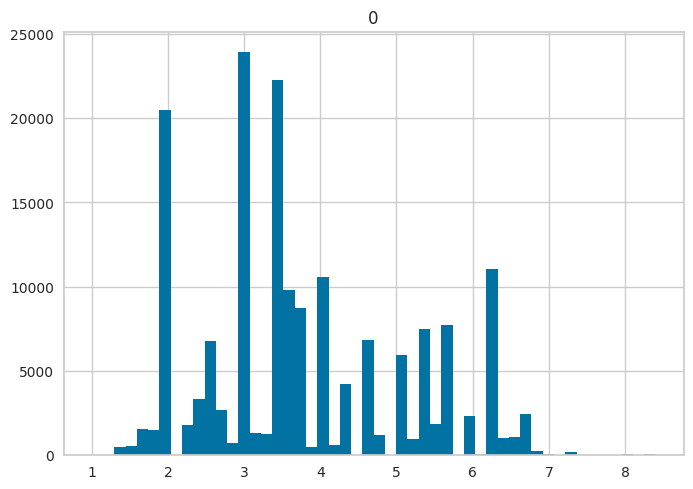

In [40]:
training_data.engine.str.extract(r'(\d+\.\d)L').astype('float').hist(bins=50)

<Axes: ylabel='engine'>

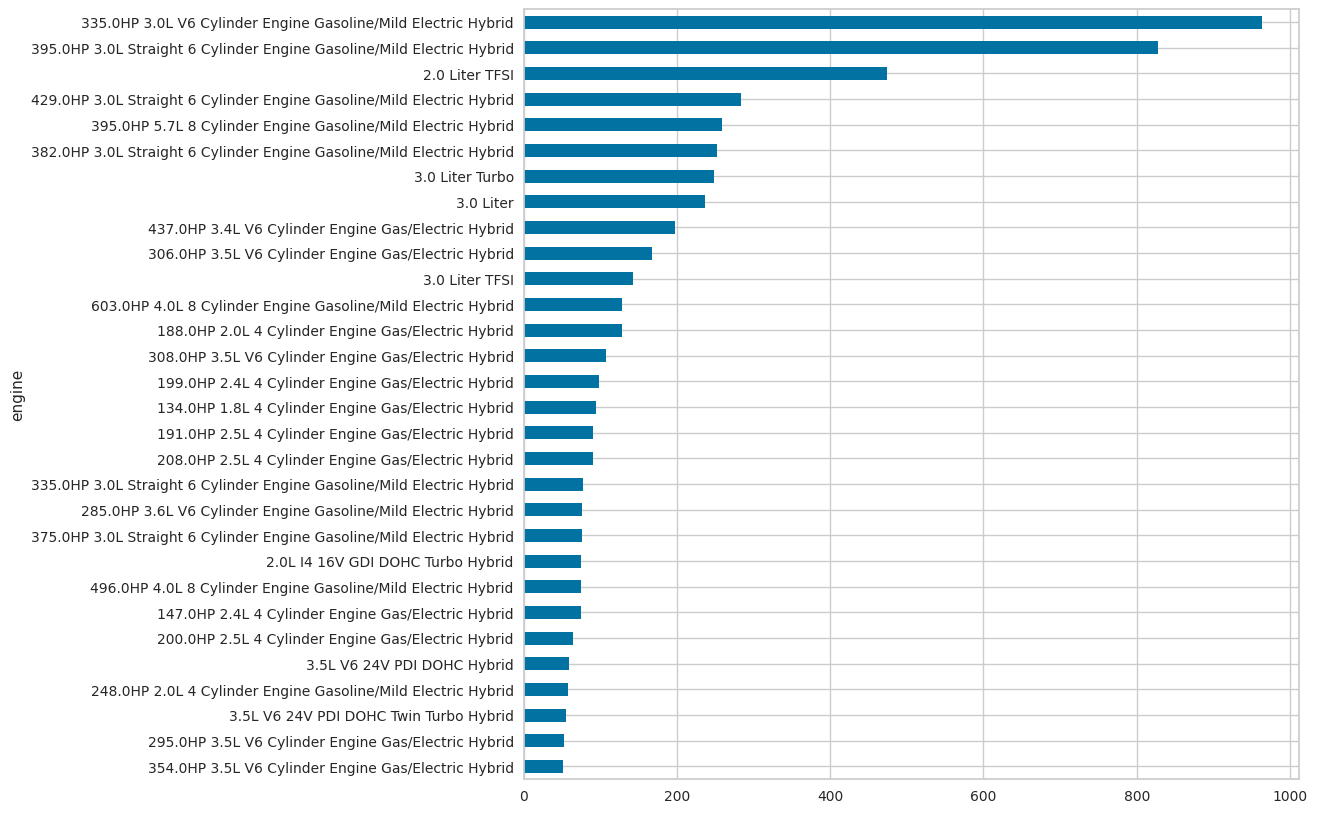

In [41]:
training_data.query('fuel_type=="Hybrid"').groupby('engine').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='engine'>

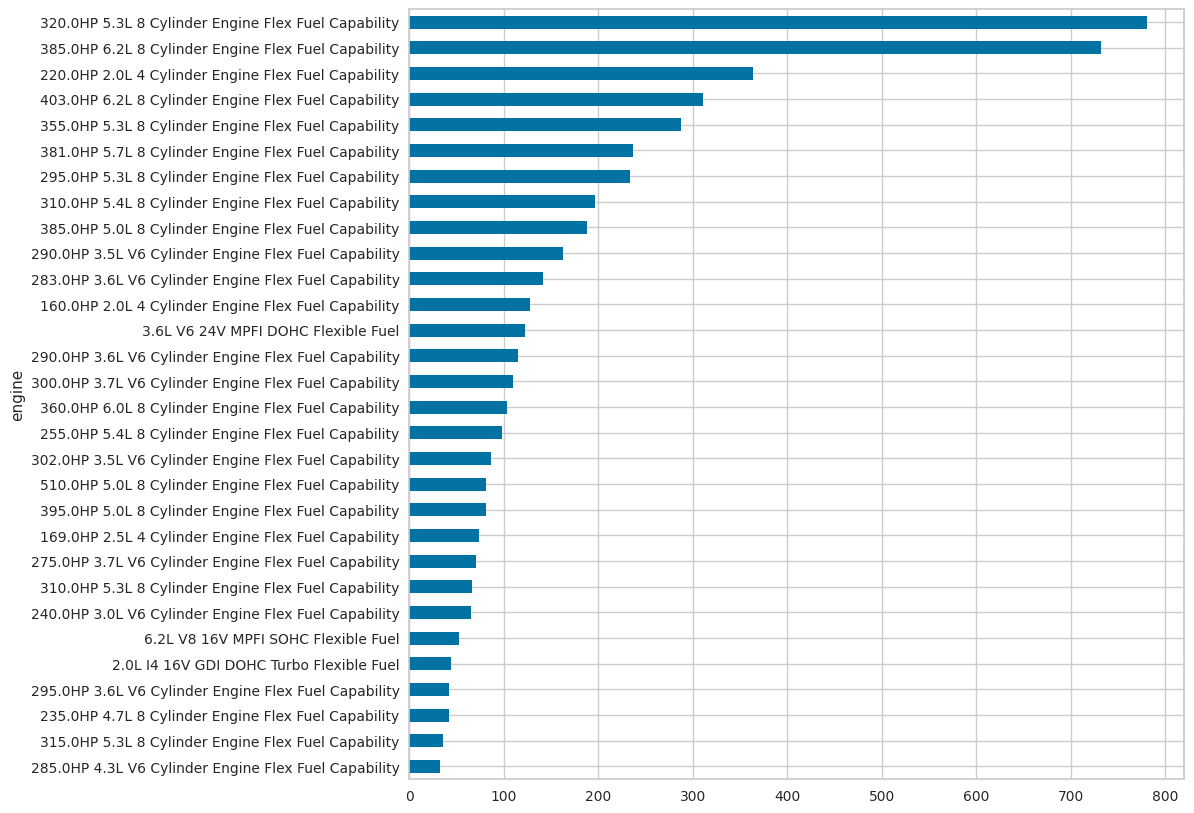

In [42]:
training_data.query('fuel_type=="E85 Flex Fuel"').groupby('engine').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='engine'>

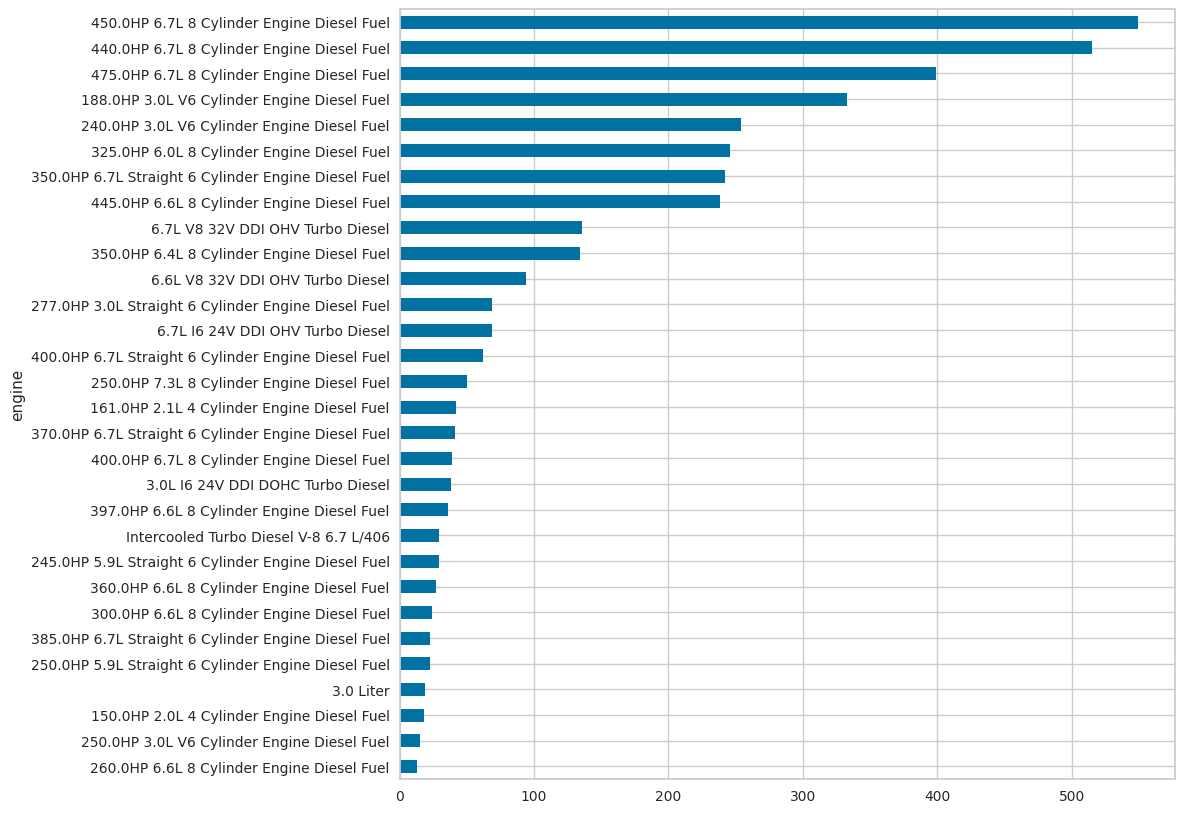

In [43]:
training_data.query('fuel_type=="Diesel"').groupby('engine').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='engine'>

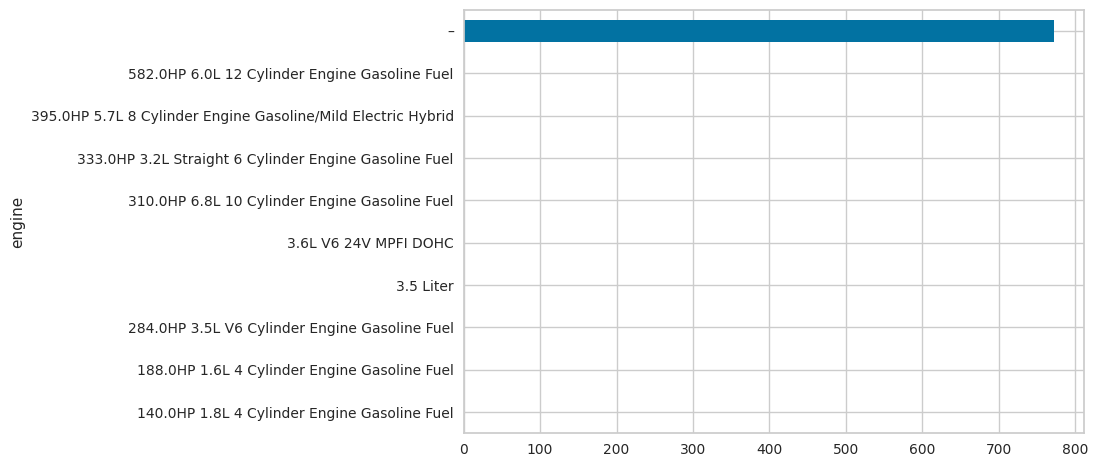

In [44]:
training_data.query('fuel_type=="–"').groupby('engine').count()['id'].sort_values().plot(kind='barh')

problematic fuel goes (mostly) with problematic engine, but not always.

<Axes: ylabel='engine'>

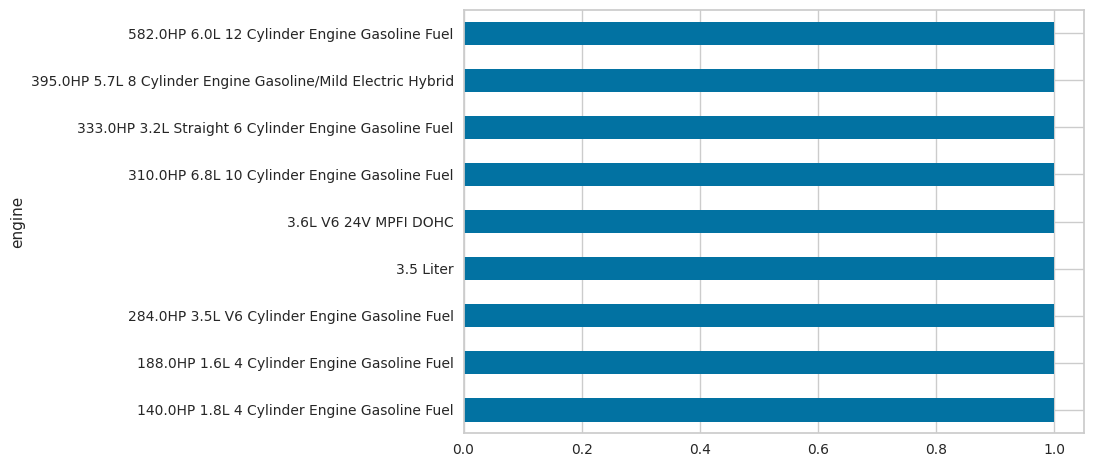

In [45]:
training_data.query('fuel_type=="–" and engine!="–"').groupby('engine').count()['id'].sort_values().plot(kind='barh')

<Axes: ylabel='engine'>

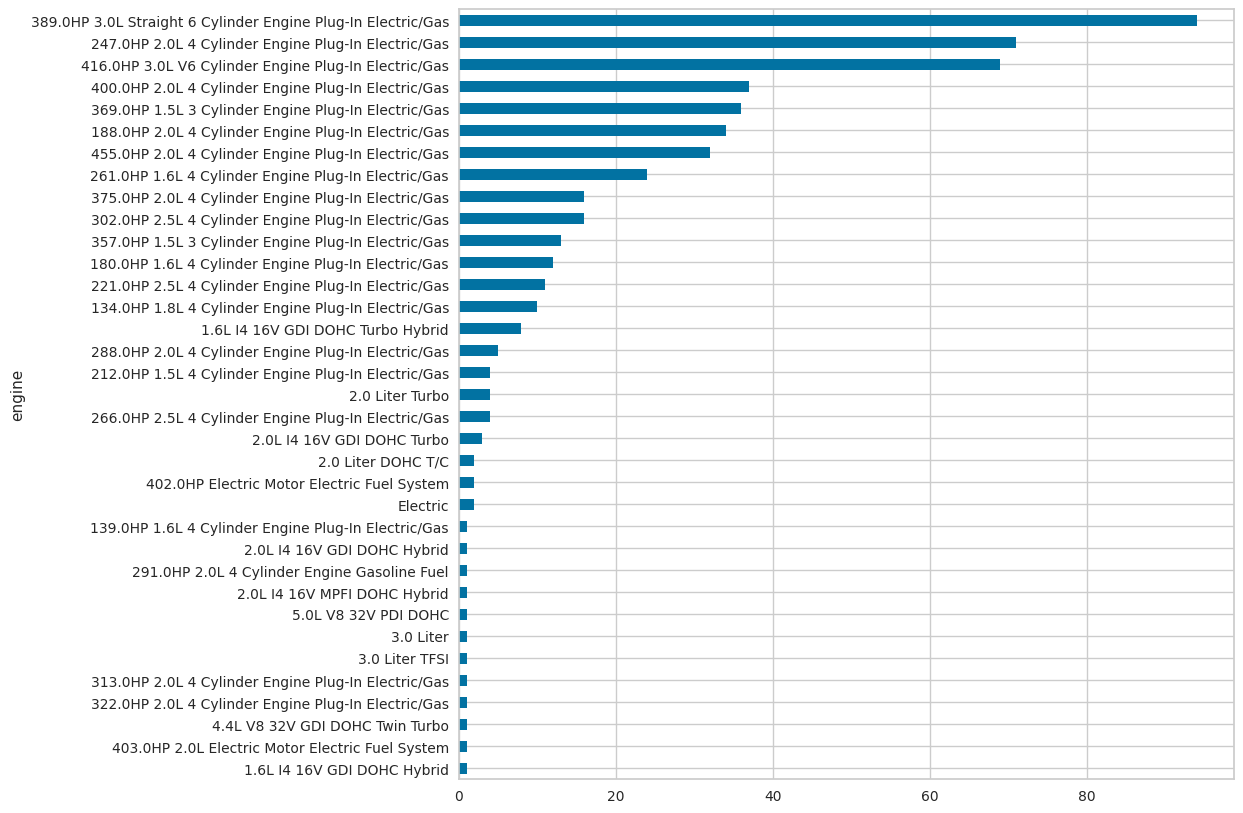

In [46]:
training_data.query('fuel_type=="Plug-In Hybrid"').groupby('engine').count()['id'].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='engine'>

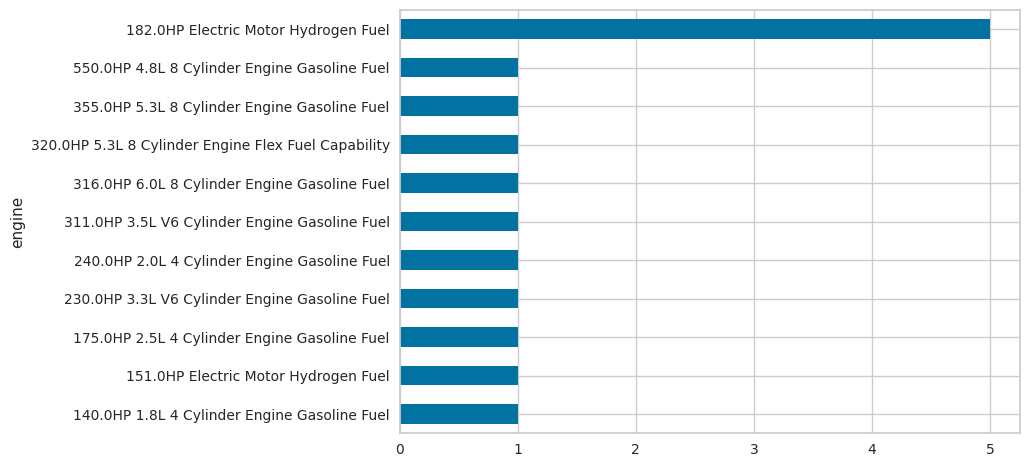

In [47]:
training_data.query('fuel_type=="not supported"').groupby('engine').count()['id'].sort_values().plot(kind='barh')

In [48]:
training_data.transmission.isna().sum()

0

<Axes: ylabel='transmission'>

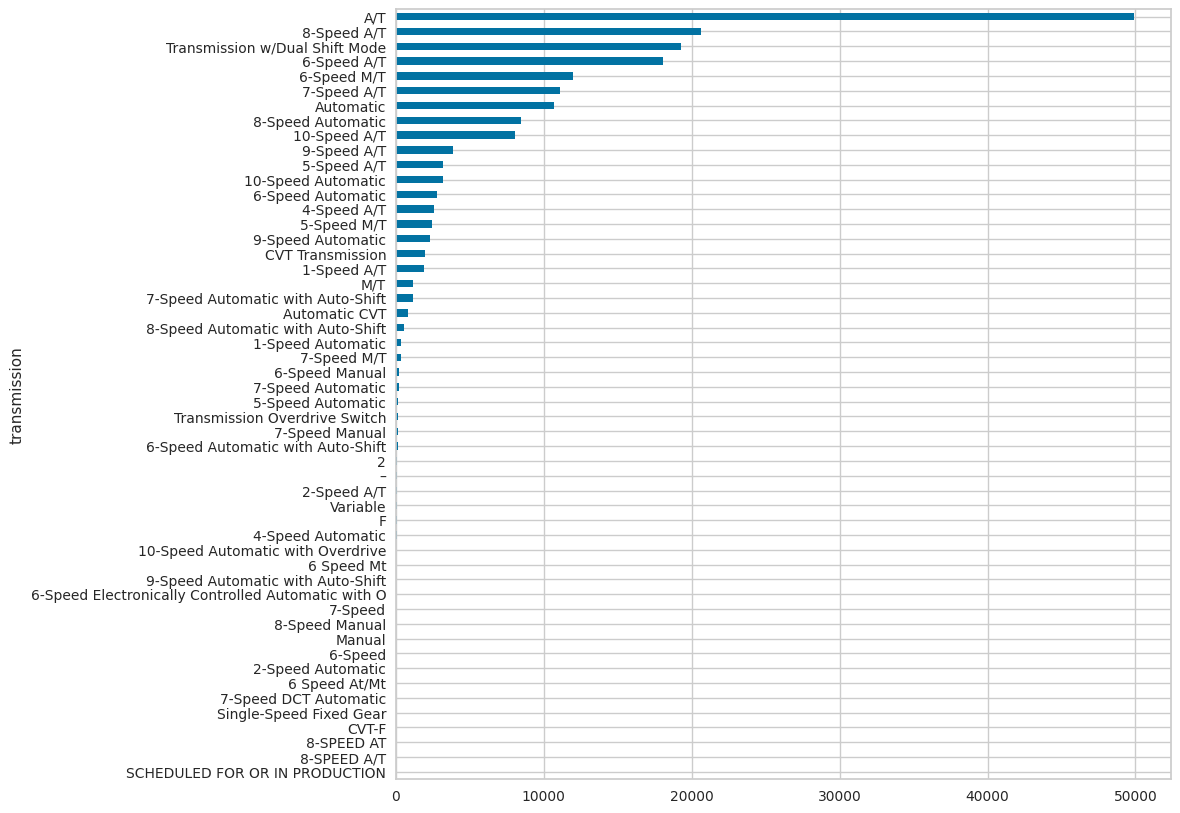

In [49]:
training_data.groupby('transmission').count()['id'].sort_values().plot(kind='barh',figsize=[10,10])

extract automatic vs manual, speed number.

<Axes: >

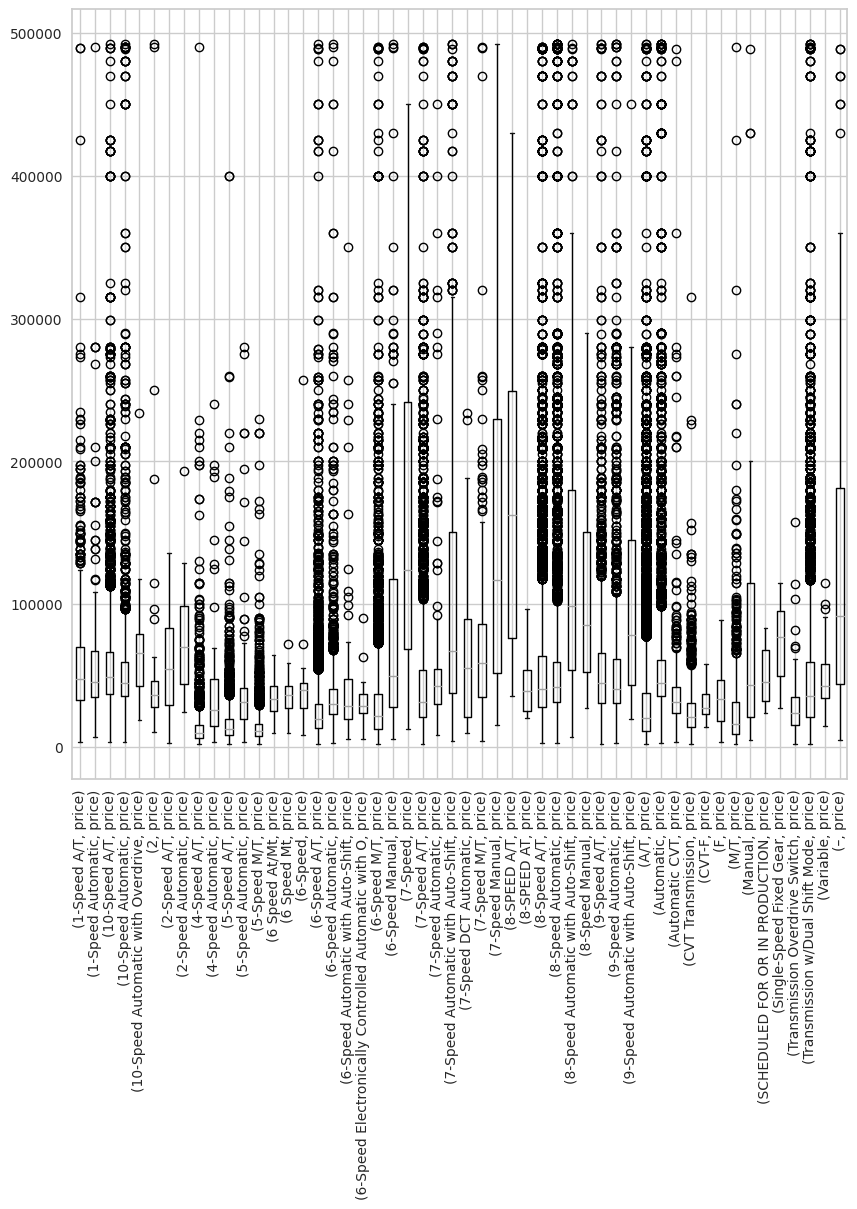

In [50]:
training_data.query('price<500_000')[['price','transmission']].groupby('transmission').boxplot(subplots=False,rot=90,figsize=[10,10])

<Axes: ylabel='fuel_type'>

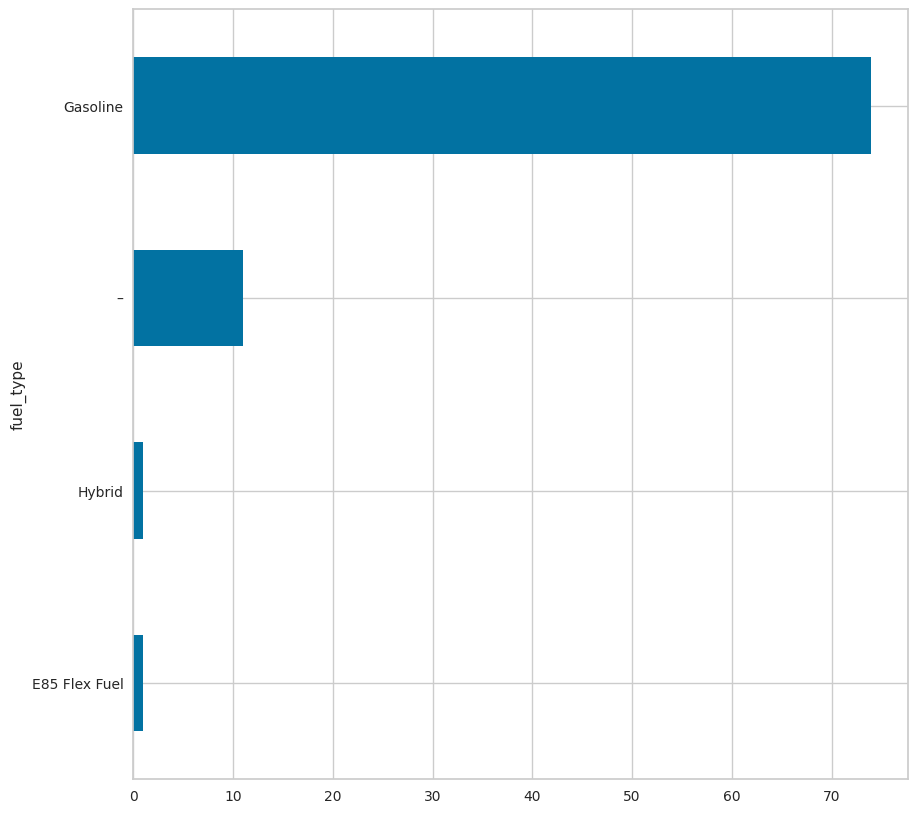

In [51]:
training_data.query('transmission=="–"').groupby('fuel_type').count()['id'].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='engine'>

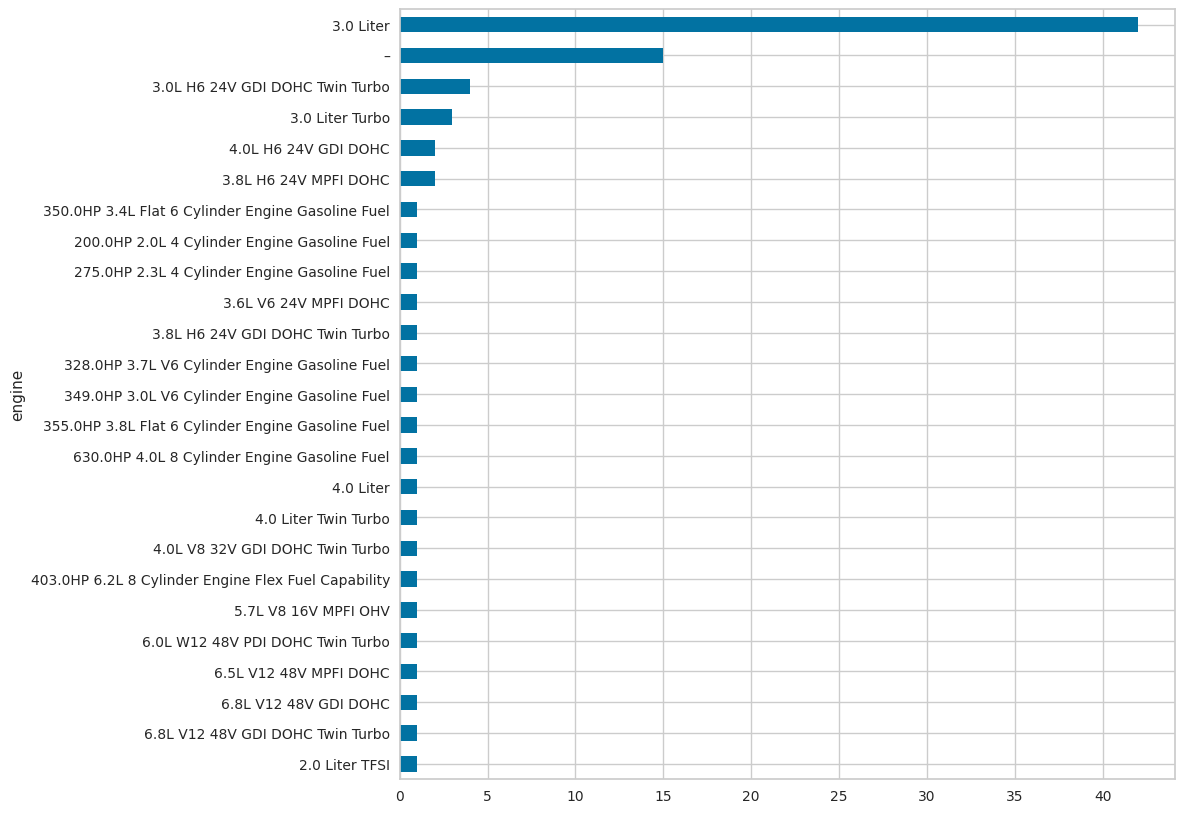

In [52]:
training_data.query('transmission=="–"').groupby('engine').count()['id'].sort_values().plot(kind='barh',figsize=[10,10])

## Colours

<Axes: ylabel='ext_col'>

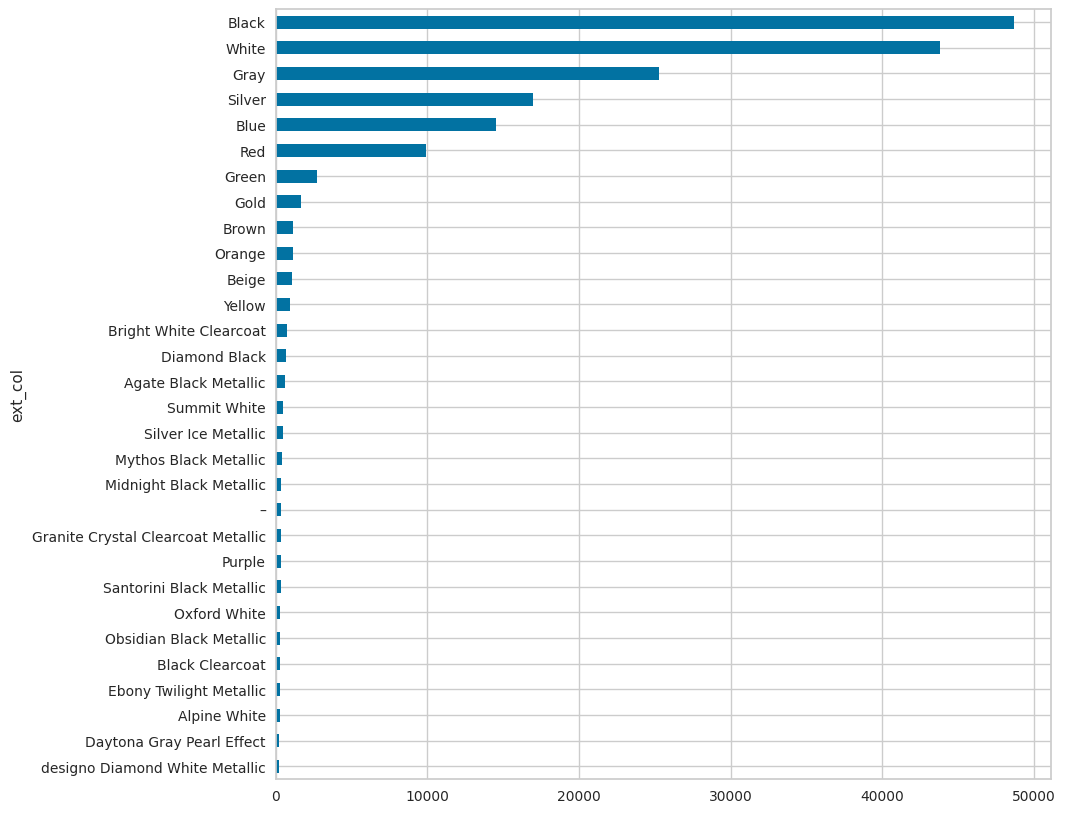

In [53]:
training_data.groupby('ext_col').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

<Axes: ylabel='int_col'>

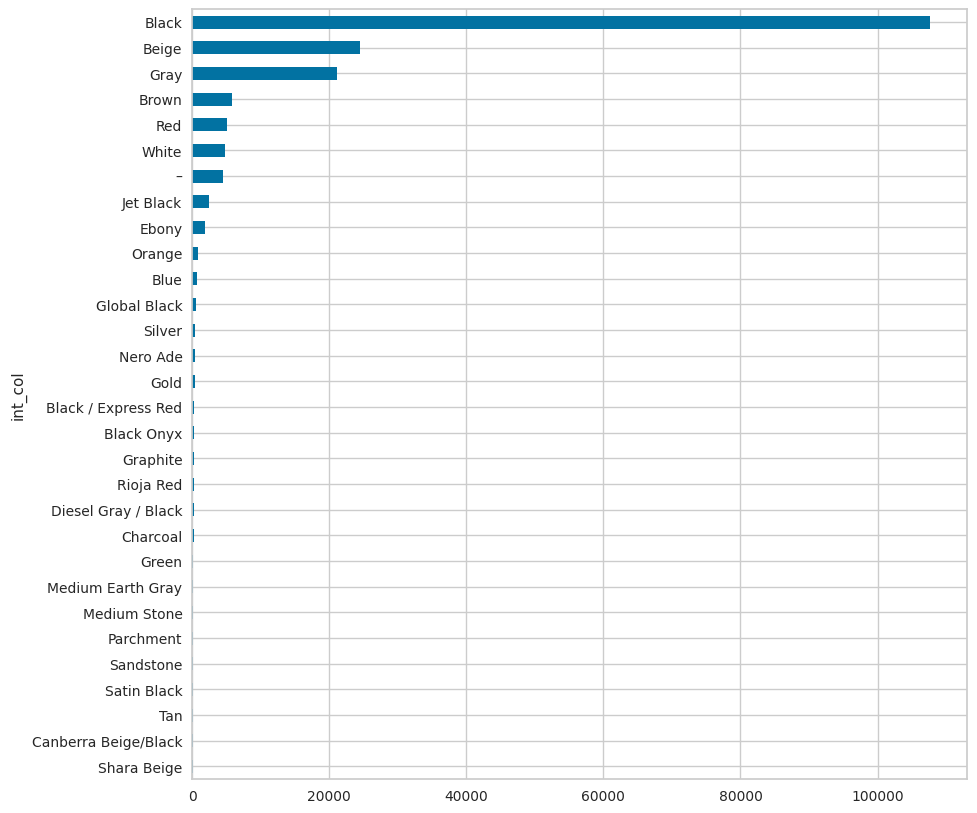

In [54]:
training_data.groupby('int_col').count()['id'].sort_values(ascending=False).iloc[0:30].sort_values().plot(kind='barh',figsize=[10,10])

## Accident etc. 

<Axes: xlabel='accident'>

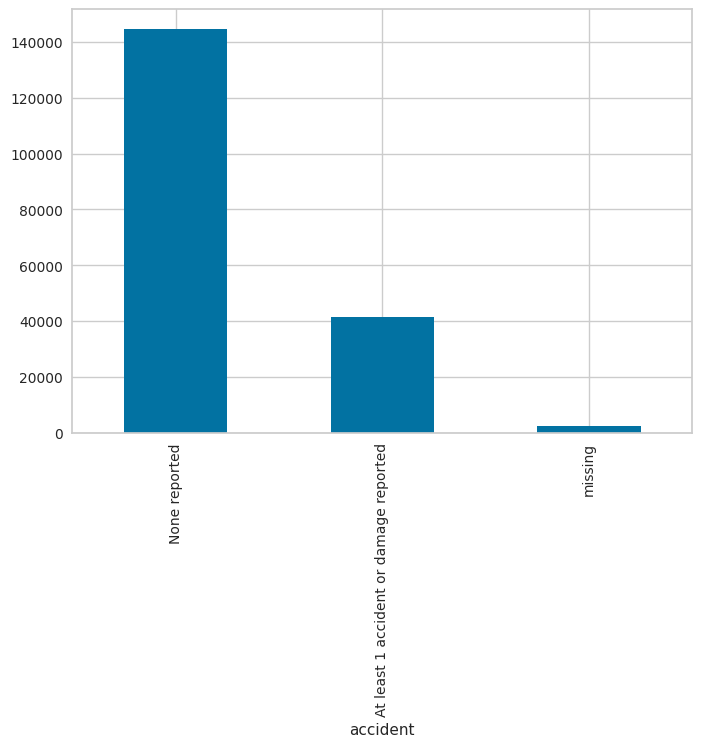

In [55]:
training_data.fillna("missing").groupby('accident').count()['id'].sort_values(ascending=False).plot(kind='bar')

<Axes: >

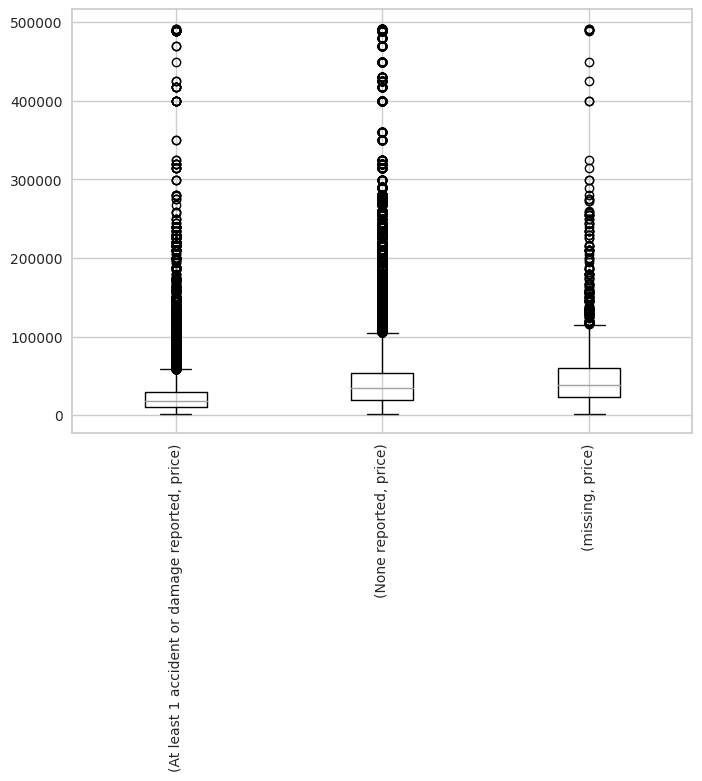

In [56]:
training_data.fillna("missing").query('price<500_000')[['price','accident']].groupby('accident').boxplot(subplots=False,rot=90)

maybe when it's missing it's safe to assume none reported?

<Axes: xlabel='accident'>

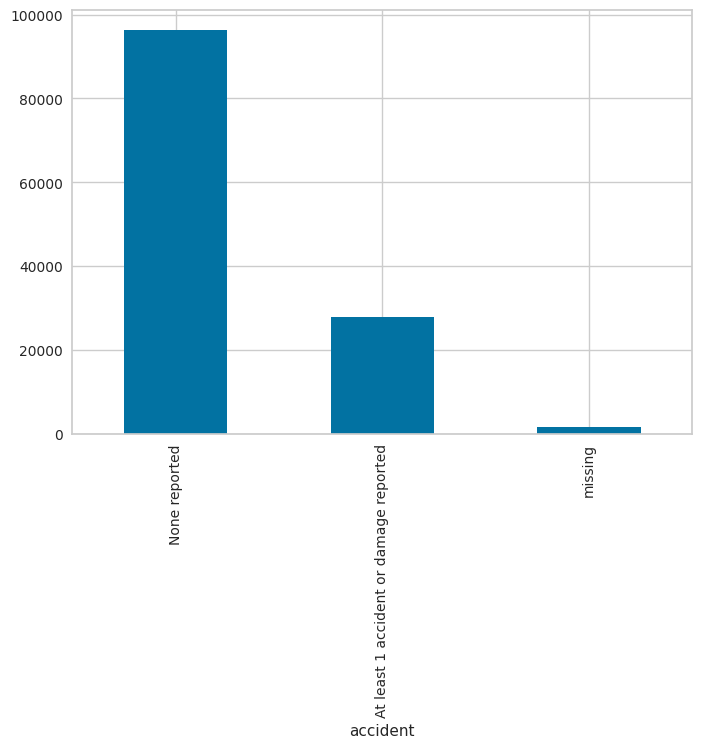

In [57]:
test_data.fillna("missing").groupby('accident').count()['id'].sort_values(ascending=False).plot(kind='bar')

array([<Axes: title={'center': 'At least 1 accident or damage reported'}>,
       <Axes: title={'center': 'None reported'}>], dtype=object)

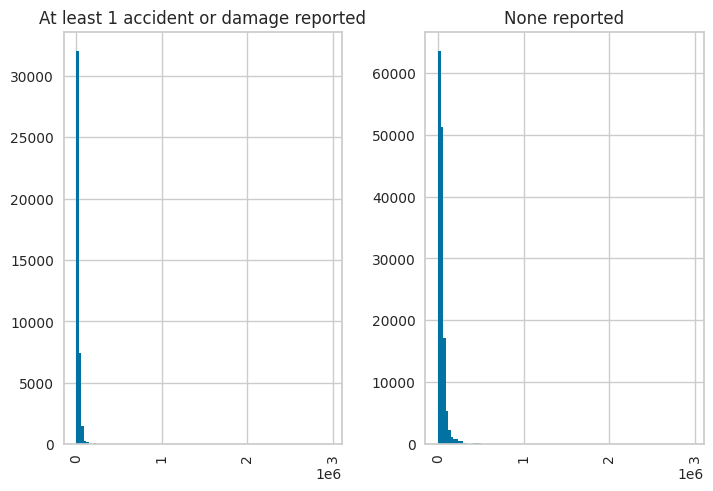

In [58]:
training_data[['accident','price']].hist(by='accident',bins=100)#.count()['id'].sort_values(ascending=False).plot(kind='barh')

<Axes: xlabel='clean_title'>

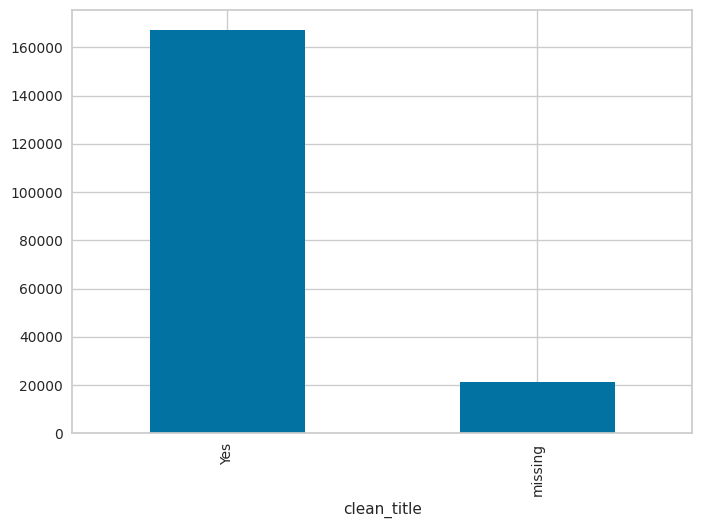

In [59]:
training_data.fillna("missing").groupby('clean_title').count()['id'].plot(kind='bar')

In [60]:
training_data.clean_title.isna().sum()

21419

what's the point of this column? does NaN mean unclean title?

<Axes: xlabel='clean_title'>

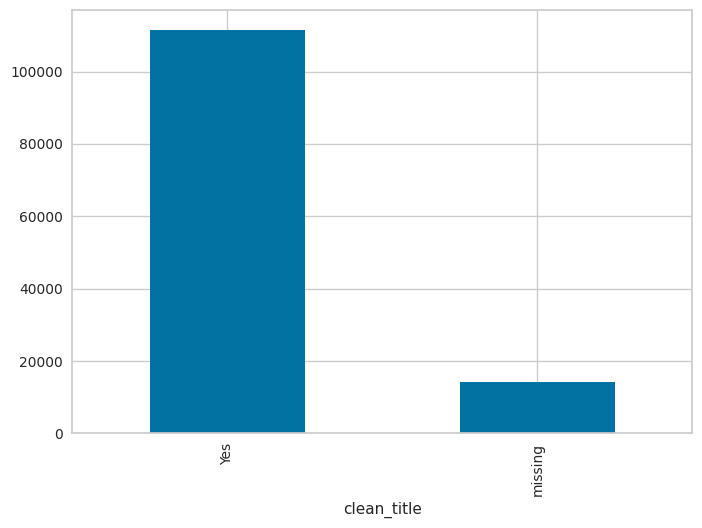

In [61]:
test_data.fillna("missing").groupby('clean_title').count()['id'].plot(kind='bar')

# regression

In [62]:
def process_data(df):
    return (df
            .assign(
                #reverse_age=training_data.model_year-training_data.model_year.min(),
                #reverse_mileage=training_data.milage.max()-training_data.milage,
                horsepower=df.engine.str.extract(r'(\d+\.\d)HP').fillna('0.0').astype('float'),
                litres=df.engine.str.extract(r'(\d+\.\d)L').fillna('0.0').astype('float'),
                cylinders=df.engine.str.extract(r'(\d+)\sCylinder').fillna('0').astype('int')
            )
            .select_dtypes('number')
            .drop(columns=['id'])#,'model_year','milage'
           )


In [63]:
non_outliers='model_year>1980 and price <390_000 and milage<280_000 '
X = training_data.query(non_outliers).pipe(process_data).query('horsepower>0 and litres>0 and cylinders>0').drop(columns='price')
y = training_data.query(non_outliers).pipe(process_data).query('horsepower>0 and litres>0 and cylinders>0').price

In [64]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)


In [65]:
lr = linear_model.LinearRegression()#positive=True

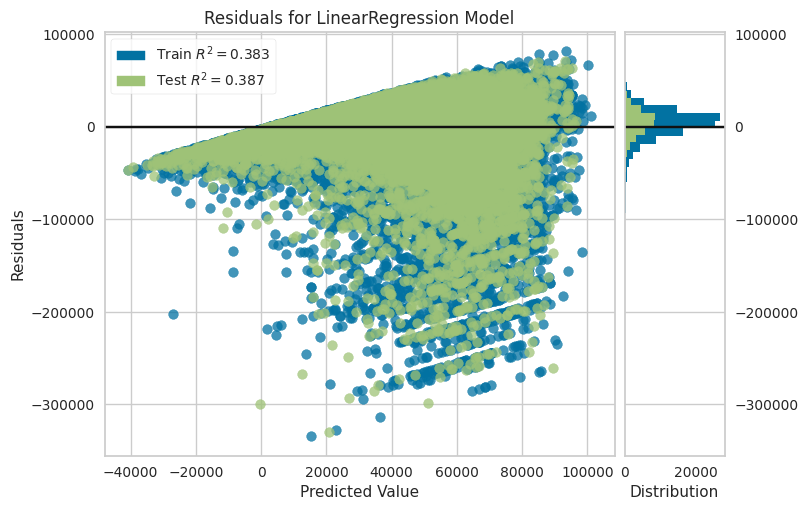

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

The best possible score is 1.0 

Test dataset behaves similarly to train dataset. But model choice fundamentally wrong!

In [67]:
lr.intercept_


-2160940.5941819116

In [68]:
pd.Series(lr.coef_, index=lr.feature_names_in_)


model_year    1083.264752
milage          -0.209817
horsepower      87.348634
litres       -2046.473876
cylinders     1311.991515
dtype: float64

array([[<Axes: xlabel='model_year', ylabel='model_year'>,
        <Axes: xlabel='milage', ylabel='model_year'>,
        <Axes: xlabel='horsepower', ylabel='model_year'>,
        <Axes: xlabel='litres', ylabel='model_year'>,
        <Axes: xlabel='cylinders', ylabel='model_year'>,
        <Axes: xlabel='price', ylabel='model_year'>],
       [<Axes: xlabel='model_year', ylabel='milage'>,
        <Axes: xlabel='milage', ylabel='milage'>,
        <Axes: xlabel='horsepower', ylabel='milage'>,
        <Axes: xlabel='litres', ylabel='milage'>,
        <Axes: xlabel='cylinders', ylabel='milage'>,
        <Axes: xlabel='price', ylabel='milage'>],
       [<Axes: xlabel='model_year', ylabel='horsepower'>,
        <Axes: xlabel='milage', ylabel='horsepower'>,
        <Axes: xlabel='horsepower', ylabel='horsepower'>,
        <Axes: xlabel='litres', ylabel='horsepower'>,
        <Axes: xlabel='cylinders', ylabel='horsepower'>,
        <Axes: xlabel='price', ylabel='horsepower'>],
       [<Axes: xlab

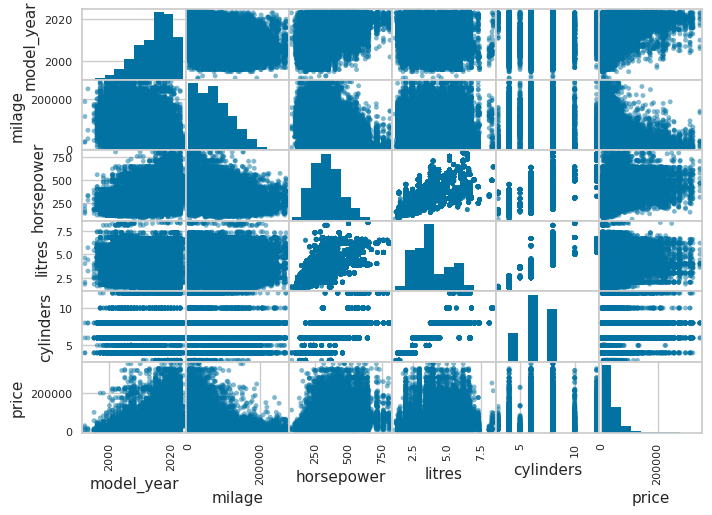

In [69]:
pd.plotting.scatter_matrix(X_train.assign(price = training_data.price))

In [70]:
price_comparison=X_train.assign(price = training_data.price, price_eval = lr.predict(X_train))


/opt/conda/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='price', ylabel='price_eval'>

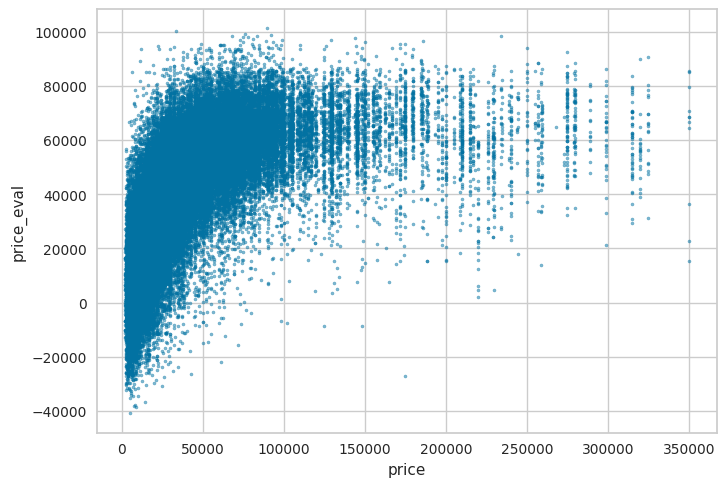

In [71]:
price_comparison.plot(kind='scatter',x='price',y='price_eval',alpha=0.5,marker='.')

<Axes: xlabel='price', ylabel='price_eval'>

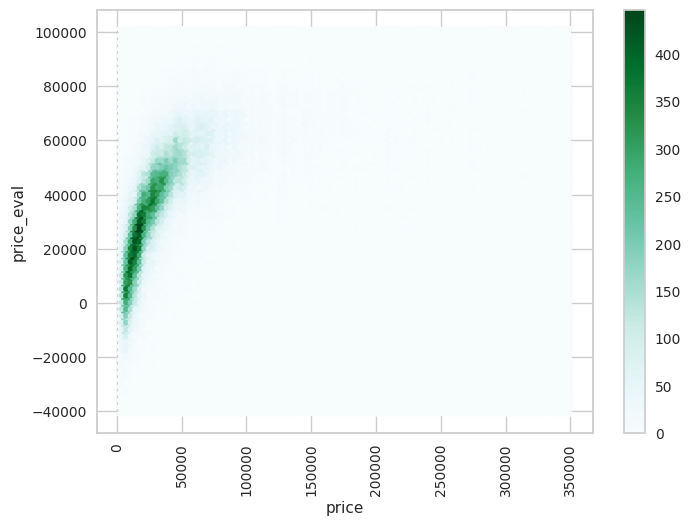

In [72]:
price_comparison.plot(kind='hexbin',x='price',y='price_eval',rot=90)


Clearly non linear relationship

In [73]:
y_pred = lr.predict(test_data.pipe(process_data))


In [74]:
pd.DataFrame(test_data.id).assign(price =y_pred).to_csv('submission.csv',index=False)